In [1]:
#!/usr/bin/env python
from __future__ import division
import argparse 
import numpy as np
import os
import GPy
import matplotlib.pyplot as plt
from fipy import *
from scipy.interpolate import griddata
from pdb import set_trace as keyboard
import time
import matplotlib
matplotlib.use('PS')
%matplotlib inline
from matplotlib.backends.backend_pdf import PdfPages
import random 

 /Users/sharmila/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning:
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.



In [2]:
# used seed 0 for training data, seed 23 for testing data
seed=23
os.environ['PYTHONHASHSEED'] = '0'
# Setting the seed for numpy-generated random numbers
np.random.seed(seed=seed)
# Setting the seed for python random numbers
random.seed(seed)

num_samples=1000    # Number of samples of the random inputs.

In [3]:
nx1=32
nx2=32

kern_1=GPy.kern.RBF
ellx1_1=2
ellx2_1=2
variance_1=0.25

kern_2=GPy.kern.RBF
ellx1_2=0.1
ellx2_2=0.1
variance_2=0.75

In [4]:
#define a mean function
def mean_1(x):
    return x

#define a mean function
def mean_2(x):
    n = x.shape[0]
    return np.zeros((n, 1))

#GPy kernel
k_1=kern_1(input_dim = 2,
       lengthscale = [ellx1_1, ellx2_1],
       variance = variance_1,
       ARD = True)

# GPy kernel
k_2=kern_2(input_dim = 2,
       lengthscale = [ellx1_2, ellx2_2],
       variance = variance_2,
       ARD = True)

In [5]:
#defining mesh to get cellcenters
Lx1 = 1.  # always put . after 1 
Lx2 = 1.  # always put . after 1 
mesh = Grid2D(nx=nx1, ny=nx2, dx=Lx1/nx1, dy=Lx2/nx2) # with nx1*nx2 number of cells/cellcenters/pixels/pixelcenters
cellcenters = mesh.cellCenters.value.T # (nx1*nx2,2) matrix

np.save('cellcenters_nx1='+str(nx1)+'_nx2='+str(nx2)+'.npy', cellcenters)

print cellcenters 

[[0.015625 0.015625]
 [0.046875 0.015625]
 [0.078125 0.015625]
 ...
 [0.921875 0.984375]
 [0.953125 0.984375]
 [0.984375 0.984375]]


In [6]:
#define matrices to save results 
inputs = np.zeros((num_samples, nx1*nx2))

start = time.time()

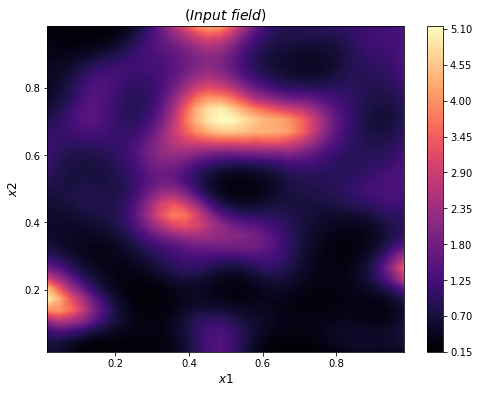

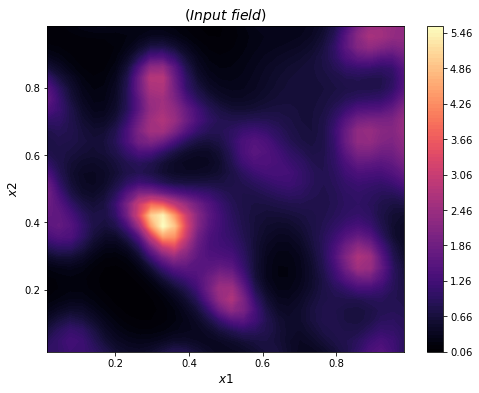

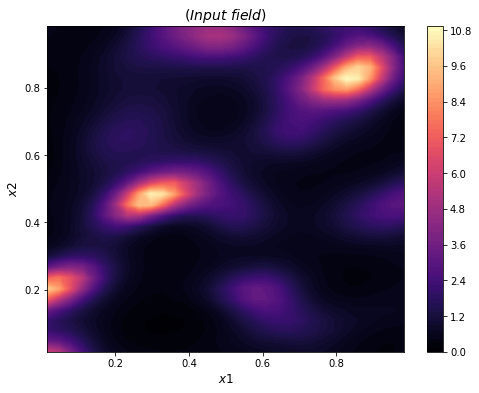

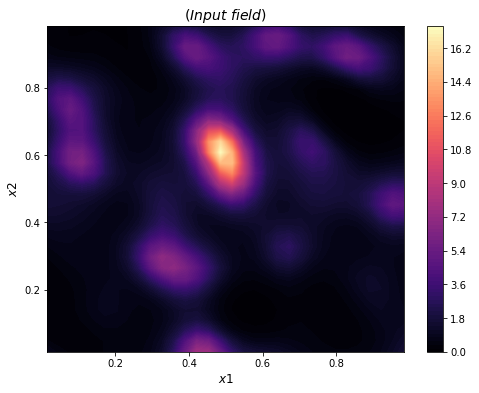

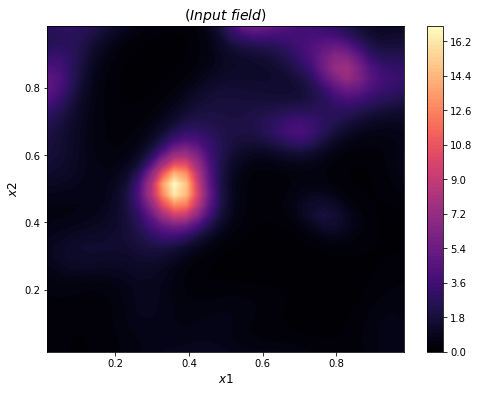

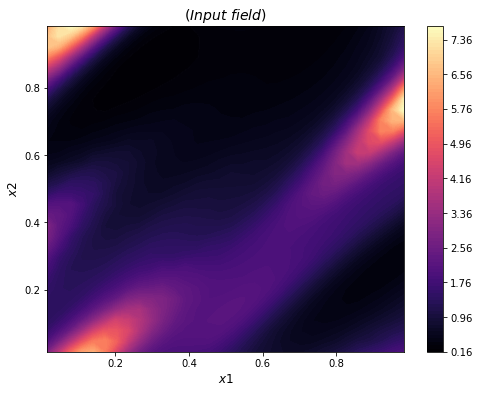

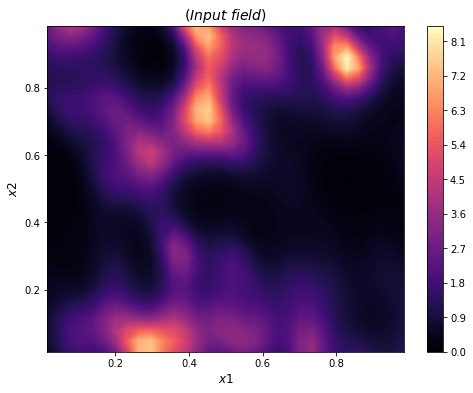

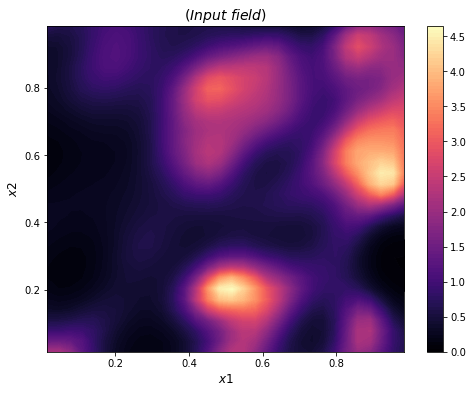

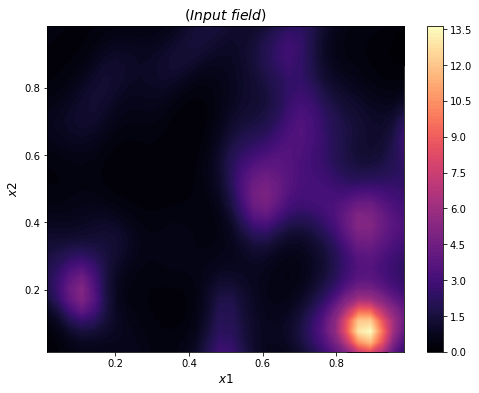

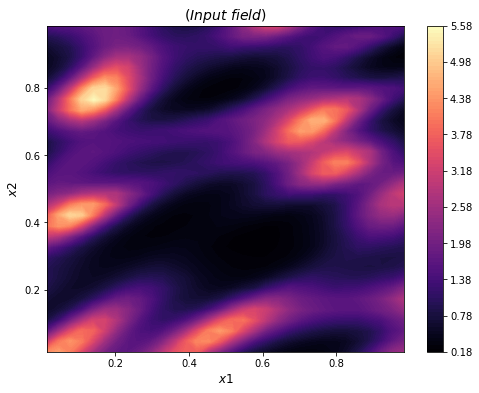

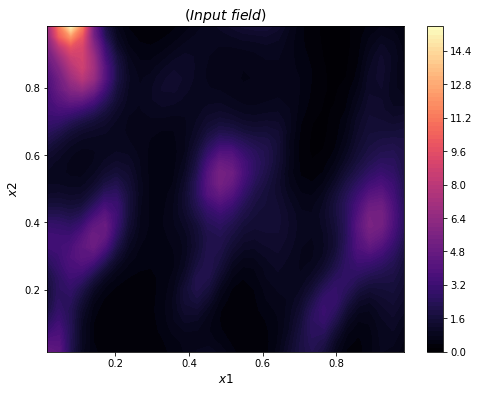

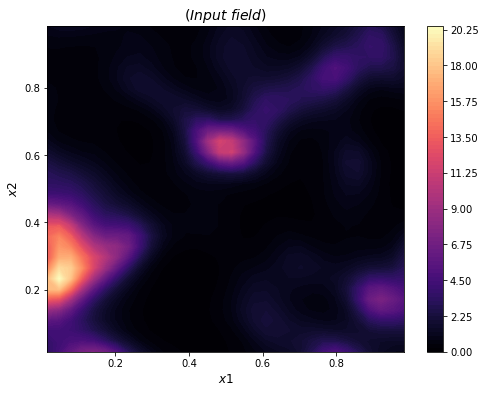

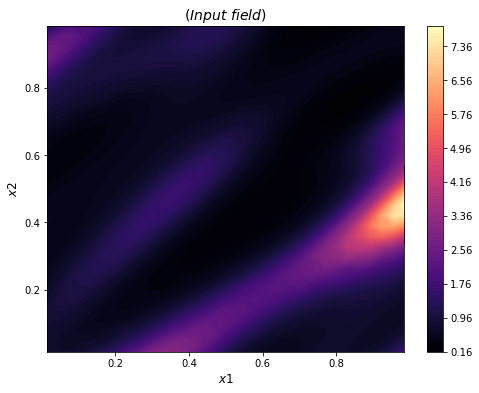

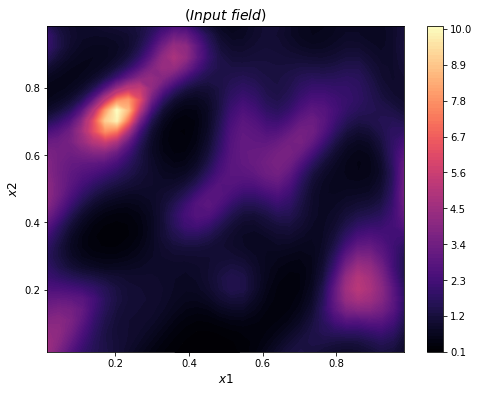

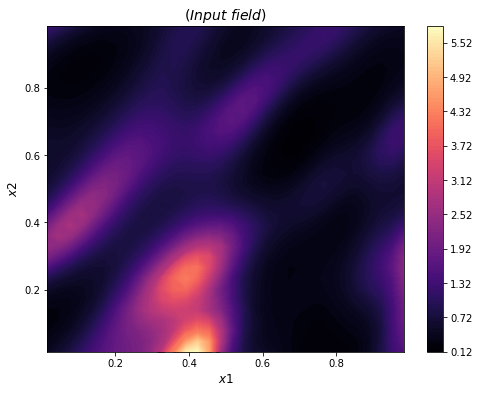

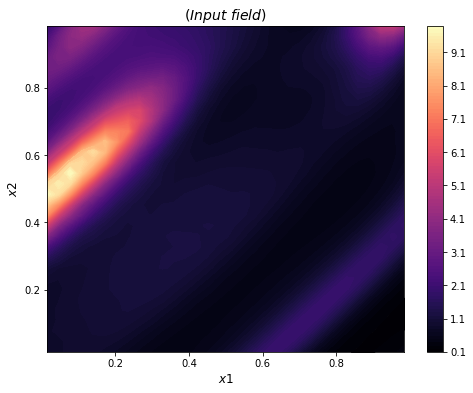

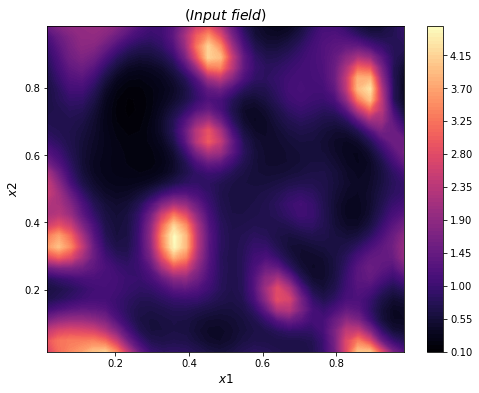

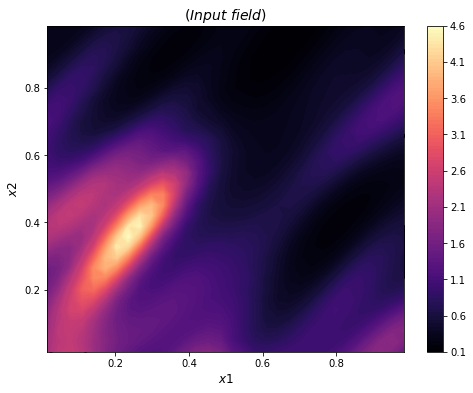

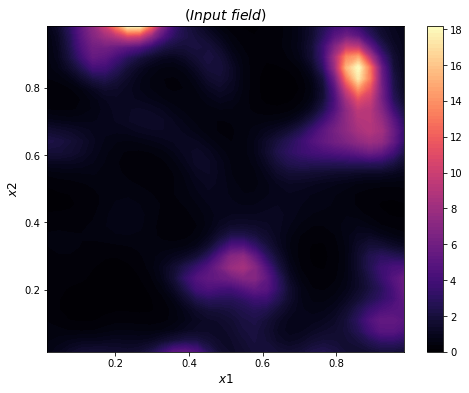

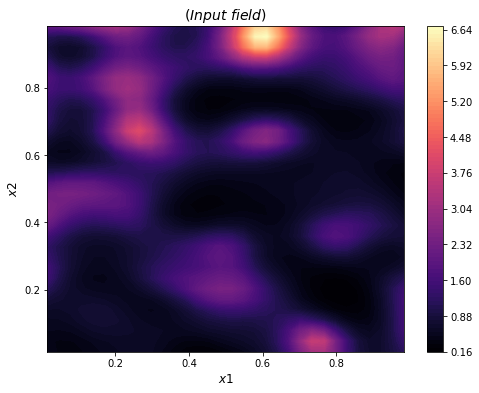

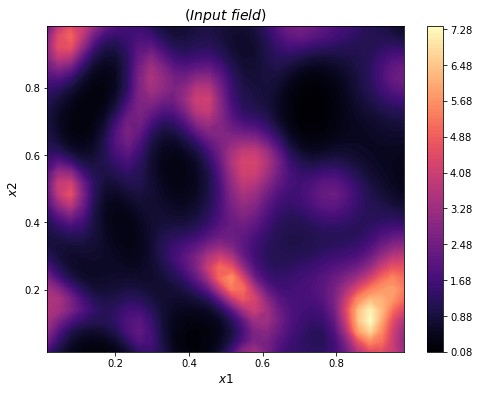

Generating sample 100
Generating sample 200
Generating sample 300
Generating sample 400
Generating sample 500
Generating sample 600
Generating sample 700
Generating sample 800
Generating sample 900
Generating sample 1000
Time (sec) to generate 1000 samples : 158.485918045
[[0.63063163 0.52282263 0.3714003  ... 1.21864906 1.24359336 1.32462789]
 [1.03152631 1.07002414 1.18852378 ... 2.50703106 2.3601013  2.2800308 ]
 [5.78916387 5.2571205  3.73197224 ... 1.40142501 0.93164349 0.68380541]
 ...
 [0.75338136 1.22546669 1.76208927 ... 2.34029464 1.90798978 1.54400035]
 [0.8043322  0.87923746 0.95324815 ... 0.64971036 0.45879617 0.41103131]
 [1.67753849 1.94013558 2.14286343 ... 0.40419688 0.55485761 0.78557637]]
(1000, 1024)


In [7]:
# pdf_pages = PdfPages('warped_GRF_samples.pdf')

#generate samples
for i in xrange(num_samples):
    #display
    if (i+1)%100 == 0:
        print "Generating sample "+str(i+1)

    #get covariance matrix and compute its Cholesky decomposition
    m_1 = mean_1(cellcenters)
    nugget = 1e-6 # This is a small number required for stability
    Cov_1 = k_1.K(cellcenters) + nugget * np.eye(cellcenters.shape[0])
    L_1 = np.linalg.cholesky(Cov_1)

    #generate a sample 
    z_1 = np.random.randn(cellcenters.shape[0], 1)
    f_1 = m_1 + np.dot(L_1, z_1)

#     print f_1
#     print np.shape(f_1)
    
    #get covariance matrix and compute its Cholesky decomposition
    m_2 = mean_2(f_1)
    nugget = 1e-6 # This is a small number required for stability
    Cov_2 = k_2.K(f_1) + nugget * np.eye(f_1.shape[0])
    L_2 = np.linalg.cholesky(Cov_2)

    #generate a sample 
    z_2 = np.random.randn(f_1.shape[0], 1)
    f_2 = m_2 + np.dot(L_2, z_2)

#     print f_2
#     print np.shape(f_2)

    sample = np.exp(f_2)
    #save data 
    inputs[i] = sample.ravel()
    
    if i<=20:
        # Plotting
        x1_f = cellcenters[:,0][:,None] # x1-coordinates of cell centers (nx1*nx2,1) matrix
        x2_f = cellcenters[:,1][:,None] # x2-coordinates of cell centers (nx1*nx2,1) matrix

        fig = plt.figure(figsize=(8,6))
        ax1 = fig.add_subplot(1, 1, 1)
        c1 = ax1.contourf( x1_f.reshape((nx1,nx2)), x2_f.reshape((nx1,nx2)), sample.reshape((nx1,nx2)), 100, cmap='magma')  # set levels automatically
        # This is the fix for the white lines between contour levels (https://stackoverflow.com/questions/8263769/hide-contour-linestroke-on-pyplot-contourf-to-get-only-fills)
        for j in c1.collections:
            j.set_edgecolor("face")
        plt.colorbar(c1)
        plt.title('$(Input \ field)$', fontsize=14)
        plt.xlabel('$x1$', fontsize=12)
        plt.ylabel('$x2$', fontsize=12)

        # Done with the page
#         pdf_pages.savefig(fig)
        plt.show()

    ####################################################################################################################
# # Write the PDF document to the disk
# pdf_pages.close()

#end timer
finish = time.time() - start
print "Time (sec) to generate "+str(num_samples)+" samples : " +str(finish)
print inputs
print np.shape(inputs)

#save data
datafile = "nx1="+str(nx1)+\
            "_nx2="+str(nx2)+\
            "_num_samples="+str(num_samples)+".npy"
np.save(os.path.join(datafile), inputs)
